<a id='top'>Top</a>







Download Dataset from https://www.kaggle.com/ntnu-testimon/paysim1

Objective: Develop a machine learning model to detect the customer transaction is good or bad. 


Public Code for XGBClassifier: https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services




High Level Plan: 
1. Import data 
2. Explore: Do Exploratory Data Analysis. Find out how the data looks like in raw format.
3. Cleanse: Clean the data for any null records by pruning or imputing
4. Feature Engineering:  Identify what category of ML modelling is required.
5. Modelling: Create a ML model and test. Also save the model to be imported for runing in stream data processing






<a id='import'></a>
# 1. Import

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn2pmml import sklearn2pmml, PMMLPipeline
from sklearn2pmml.decoration import CategoricalDomain
from xgboost.sklearn import XGBClassifier



In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
#Import dataset from CSV file
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')


<a href='#top'>back to top</a>

<a id='EDA'></a>
# 2. Exploratory Data Analysis


In [5]:
#List the columns
list(df)

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [6]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [7]:
#Check whether any Null values are present
df.isnull().values.any()

False

In [8]:
#Idenfity Fradulent transactions, Ratio and some basic understanding of other factors
totalrecords = len(df)
print ('Total number of Records =', totalrecords)

is_fraud = len(df.loc[df.isFraud == 1])

print ('Total number of Records with Fraudulent Transactions = {}'.format(len(df.loc[df.isFraud == 1])))
print ('Total number of Records with Flagged Fraudulent Transactions = {}'.format(len(df.loc[df.isFlaggedFraud == 1])))

       
print('Percentage Ratio of Fradulent Transactions=', is_fraud*100/totalrecords)
print ('Total number of Records with type PAYMENT = {}'.format(len(df.loc[df.type == "PAYMENT"]))) 
print ('Total number of Records with type TRANSFER = {}'.format(len(df.loc[df.type == "TRANSFER"])))
print ('Total number of Records with type CASH_IN = {}'.format(len(df.loc[df.type == "CASH_IN"])))
print ('Total number of Records with type CASH_OUT = {}'.format(len(df.loc[df.type == "CASH_OUT"])))
print ('Total number of Records with type DEBIT = {}'.format(len(df.loc[df.type == "DEBIT"])))

Total number of Records = 6362620
Total number of Records with Fraudulent Transactions = 8213
Total number of Records with Flagged Fraudulent Transactions = 16
Percentage Ratio of Fradulent Transactions= 0.12908204481801522
Total number of Records with type PAYMENT = 2151495
Total number of Records with type TRANSFER = 532909
Total number of Records with type CASH_IN = 1399284
Total number of Records with type CASH_OUT = 2237500
Total number of Records with type DEBIT = 41432


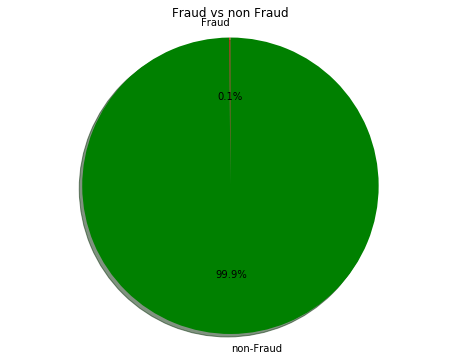

In [13]:
x =len(df[df['isFraud'] == 1])
y = len(df[df['isFraud']== 0])
plt.figure(figsize=(8,6))
# Data to plot
plt.title('Fraud vs non Fraud')
labels = 'Fraud','non-Fraud'
sizes = [x,y]
colors = ['red', 'green']
explode = (0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
 
plt.axis('equal')
plt.show()

In [14]:
#Observation: Ratio of Fraudulent transaction is very small

In [15]:
print('Fraudulent transactions types are {}'.format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) 

Fraudulent transactions types are ['TRANSFER', 'CASH_OUT']


In [16]:


print ('Total number of Records with  fraudulent TRANSFERs = {}'.format(len(df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]))) # 4097

print ('Total number of Records with fraudulent CASH_OUTs = {}'.format(len(df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]))) # 4116

print ('Total number of Records with isFlaggedfraudulent with TRANSFERs = {}'.format(len(df.loc[(df.isFlaggedFraud   == 1) & (df.type == 'TRANSFER')])))

print ('Total number of Records with  isFlaggedfraudulent with CASH_OUTs = {}'.format(len(df.loc[(df.isFlaggedFraud == 1) & (df.type == 'CASH_OUT')])))




Total number of Records with  fraudulent TRANSFERs = 4097
Total number of Records with fraudulent CASH_OUTs = 4116
Total number of Records with isFlaggedfraudulent with TRANSFERs = 16
Total number of Records with  isFlaggedfraudulent with CASH_OUTs = 0


<a href='#top'>back to top</a>

<a id='clean'></a>
# 3. Data Cleansing

Exploratory data analysis describes that  fraud is present only in TRANSFER and CASH_OUT categrories. Based on the result, we build a limited dataset of all TRANSFER and CASH_OUT 

In [17]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [18]:
print(X.head())

    step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     0     181.00          181.0             0.0             0.0   
3      1     1     181.00          181.0             0.0         21182.0   
15     1     1  229133.94        15325.0             0.0          5083.0   
19     1     0  215310.30          705.0             0.0         22425.0   
24     1     0  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  
2             0.00  
3             0.00  
15        51513.44  
19            0.00  
24      2719172.89  


<a href='#top'>back to top</a>

In [19]:
#Idenfity the Skewness in the data. 
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


# Building Machine Learning Model

## 1)Using XGBoost Classifier

In [55]:
#Splittingdata into training and test sets with a ratio 80:20
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

In [80]:
# Takes time to compute
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

AUPRC = 0.9436219544389146


In [ ]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(slf, height = 1, color = colours, grid = False, show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

In [ ]:
to_graphviz(slf)

In [31]:
clf.save_model("fin_pay_fraud.ml")
print("Saved Model")

Saved Model


In [20]:
slf= XGBClassifier()
slf.load_model("fin_pay_fraud.ml")
print("loaded model")

loaded model


In [71]:
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf1 =  XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
pipeline =  PMMLPipeline([("estimator", clf2)])


sklearn2pmml(pipeline,"fin_pay_fraud-xgb.pmml", with_repr=True)

/Users/tvengal/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Standard output is empty
Standard error:
Jun 12, 2020 1:38:10 PM org.jpmml.sklearn.Main run
INFO: Parsing PKL..
Jun 12, 2020 1:38:10 PM org.jpmml.sklearn.Main run
INFO: Parsed PKL in 12 ms.
Jun 12, 2020 1:38:10 PM org.jpmml.sklearn.Main run
INFO: Converting..
Jun 12, 2020 1:38:10 PM sklearn2pmml.pipeline.PMMLPipeline initTargetFields
Jun 12, 2020 1:38:10 PM org.jpmml.sklearn.Main run
SEVERE: Failed to convert
java.lang.IllegalArgumentException: Attribute 'xgboost.sklearn.XGBClassifier._le' not set
	at org.jpmml.python.PyClassDict.get(PyClassDict.java:68)
	at sklearn.LabelEncoderClassifier.getLabelEncoder(LabelEncoderClassifier.java:40)
	at sklearn.LabelEncoderClassifier.getClasses(LabelEncoderClassifier.java:34)
	at sklearn.ClassifierUtil.getClasses(ClassifierUtil.java:32)
	at sklearn2pmml.pipeline.PMMLPipeline.encodePMML(PMMLPipeline.java:132)
	at org.jpmml.sklearn.Main.run(Main.java:233)
	at org.jpmml.sklearn.Main.main(Main.java:151)

Exception in thread "main" java.lang.IllegalArgum

RuntimeError: The JPMML-SkLearn conversion application has failed. The Java executable should have printed more information about the failure into its standard output and/or standard error streams

<a href='#top'>back to top</a>

## 2)Using RandomForest Classifier

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pickle

data = pd.read_csv("PS_20174392719_1491204439457_log.csv")


In [5]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


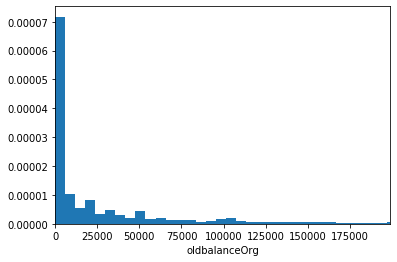

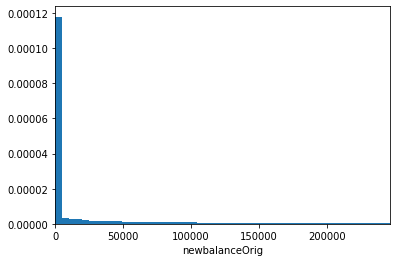

In [6]:
plt.hist(data['oldbalanceOrg'], density=True, bins=10000)  # `density=False` would make counts
plt.xlim(np.percentile(data['oldbalanceOrg'].values, 5), np.percentile(data['oldbalanceOrg'].values, 80))
# plt.ylabel('Probability')
plt.xlabel('oldbalanceOrg')
plt.show()

plt.hist(data['newbalanceOrig'], density=True, bins=10000)  # `density=False` would make counts
plt.xlim(np.percentile(data['newbalanceOrig'].values, 5), np.percentile(data['newbalanceOrig'].values, 80))
# plt.ylabel('Probability')
plt.xlabel('newbalanceOrig')
plt.show()

In [7]:
# convert the columns as Category
data['type'] = data['type'].astype('category')
data['type'] = data['type'].cat.codes
data['nameOrig'] = data['nameOrig'].astype('category')
data['nameOrig'] = data['nameOrig'].cat.codes
data['nameDest'] = data['nameDest'].astype('category')
data['nameDest'] = data['nameDest'].cat.codes
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [8]:
labels = ['isFraud', 'isFlaggedFraud']
y = data[labels]
y.head()

,isFraud,isFlaggedFraud
0,0,0
1,0,0
2,1,0
3,1,0
4,0,0


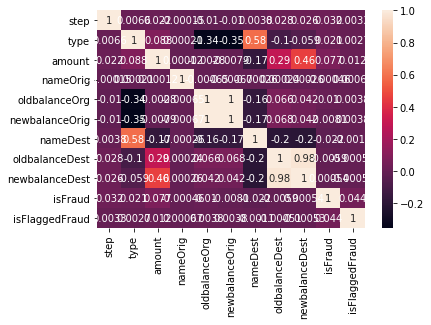

In [9]:
sns.heatmap(data.corr(), annot=True)

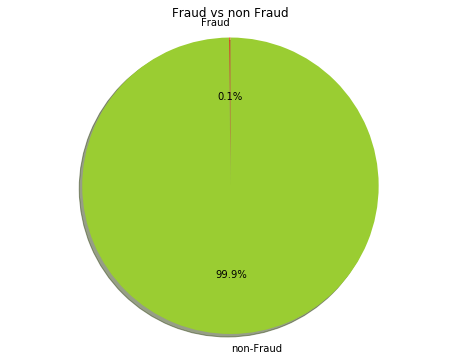

In [10]:

x =len(data[data['isFraud'] == 1])
y = len(data[data['isFraud']== 0])
plt.figure(figsize=(8,6))
# Data to plot
plt.title('Fraud vs non Fraud')
labels = 'Fraud','non-Fraud'
sizes = [x,y]
colors = ['red', 'yellowgreen']
explode = (0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
 
plt.axis('equal')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

y = data["isFraud"]
X = data.drop("isFraud", axis=1)
X = X.drop("isFlaggedFraud", axis=1)
X = X.drop("nameOrig", axis=1)
X = X.drop("nameDest", axis=1)
# X = data.drop("isFlaggedFraud", axis=1)
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0
2,1,4,181.00,181.0,0.00,0.0,0.0
3,1,1,181.00,181.0,0.00,21182.0,0.0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0


In [12]:
tuned_parameters = [{'min_samples_split': [2, 3, 4, 5, 8, 10]}, {'min_samples_leaf': [1, 2]}, {'class_weight': [None, "balanced"]}]
_scoring = "roc_auc"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)

In [48]:
# Long run time to create the model
clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [32]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_test)

In [49]:
#save the model to a pickle file


dict_ = {}
dict_['train_data'] = [X_train, y_train]
dict_['test_data'] = [X_test, y_test]
dict_['classifier'] = clf

with open('RFClassifier.pickle', 'wb') as handle:
    pickle.dump(dict_, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
with open('RFClassifier.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [16]:
data.keys()

dict_keys(['train_data', 'test_data', 'classifier'])

In [17]:
X_train, y_train = data['train_data'][0], data['train_data'][1]
X_test, y_test = data['test_data'][0], data['test_data'][1]
clf = data['classifier']

In [18]:
pred = clf.predict(X_test)
from sklearn.metrics import roc_auc_score
roc_auc_score( y_test, pred)

0.860314527078563

In [19]:
from sklearn import  metrics

metrics.confusion_matrix(y_test, pred)

array([[1270876,       5],
       [    459,    1184]])

In [ ]:
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml
clf2 =  RandomForestClassifier(n_estimators=30)
pipeline =  PMMLPipeline([("estimator", clf)])

pipeline.fit(X_train,y_train)

sklearn2pmml(pipeline,"fin_pay_fraud-rf.pmml", with_repr=True)

/Users/tvengal/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [21]:
!java -version

java version "1.8.0_251"
Java(TM) SE Runtime Environment (build 1.8.0_251-b08)
Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)


<a href='#top'>back to top</a>